<a href="https://colab.research.google.com/github/smitaforward/Data_Science/blob/master/H2o_Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.10-63ubuntu1~02).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
openjdk version "10.0.2" 2018-07-17
OpenJDK Runtime Environment (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4)
OpenJDK 64-Bit Server VM (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4, mixed mode)


In [3]:
! pip install h2o

    100% |████████████████████████████████| 120.9MB 198kB/s 
  Stored in directory: /root/.cache/pip/wheels/76/73/b8/8639930fbc56e9f26fac210f5e65dbe05a0c39396ddaf4a685
Successfully built h2o


In [4]:
import h2o
h2o.init(max_mem_size='12G')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "10.0.2" 2018-07-17; OpenJDK Runtime Environment (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4); OpenJDK 64-Bit Server VM (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4, mixed mode)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmphnd78zaf
  JVM stdout: /tmp/tmphnd78zaf/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmphnd78zaf/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.4
H2O cluster version age:,10 days
H2O cluster name:,H2O_from_python_unknownUser_sg2tfx
H2O cluster total nodes:,1
H2O cluster free memory:,12 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


# DATA

In [5]:
# Use local data file or download from GitHub
import os
docker_data_path = "/home/h2o/data/nlp/AmazonReviews.csv"
if os.path.isfile(docker_data_path):
  data_path = docker_data_path
else:
  data_path = "https://s3.amazonaws.com/tomk/h2o-world/megan/AmazonReviews.csv"


# Load data into H2O
reviews = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
#reviews['PositiveReview'] = reviews['Score']>=4
reviews['PositiveReview'] = (reviews['Score'] >= 4).ifelse('1','0')


In [27]:
reviews['PositiveReview'].table()

PositiveReview,Count
0,21791
1,78209


In [8]:
reviews.head(2)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring.",0


# Train Base Model

In [0]:
# find the 80th quantile of time
time_split=reviews['Time'].quantile(prob=[0.8])[1]

In [0]:
reviews['Train']= (reviews['Time'] < time_split).ifelse('Yes', 'No')

In [30]:
reviews.tail(2)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview,Train
B0009JRH1C,AVLEDWHKKIPHA,Good Tea,5,6,248838,Kim,6,1.29704e+09,"A nice big box so you don't have to worry about running out of tea anytime soon. Flavorful, but mild for anytime of day. I would recommend this tea.",1,Yes
B005H6FF3Y,A7WV4HI6C8WRJ,Not fit for human consumption.,1,12,149738,Edward A. Woodward,12,1.33065e+09,"I was very excited when i saw this product, i'm one of those people eager to try anything, and I've had exotic meats before in a number of ways, through friends that hunt I've enjoyed home made dishes made from a wide variety of game animals, and i've had less common animals like ostrich, kangaroo, and aligator that i ordered on like and cooked myself, and i've even had a few of these meats as jerky by other companies. I like the meats of the animals they made these jerkies from, i need to stress that point, because otherwise you may think that is what my problem is. it's not, this product was AWFUL!! these were some of the worst cured meat snacks I've ever had. Is it possible to rate something and give it no stars? because that is what this product deserves. the meat managed somehow to be both bland and surprisingly foul, and coated with enough grease to lubricate an engine. I have tried several of the strips and sticks and found that to be a universal condition. I can only think that the people who wrote the rave reviews for this product did so without tasting it. this is dreadful stuff, suited only for those who simply want the novelty of claiming they ate strange animals and don't care what it tasted like. this meat was not fit for human consumption, in fact, i wouldn't even give it to my dog. I won't be buying anything else from buffalo bob.",0,Yes


In [0]:
train = reviews[reviews['Train']== 'Yes']
valid = reviews[reviews['Train'] == 'No']


In [21]:
reviews.names

['ProductId',
 'UserId',
 'Summary',
 'Score',
 'HelpfulnessDenominator',
 'Id',
 'ProfileName',
 'HelpfulnessNumerator',
 'Time',
 'Text',
 'PositiveReview',
 'Train']

In [0]:
from h2o.estimators import H2OGradientBoostingEstimator

predictors = ['ProductId', 'UserId', 'HelpfulnessDenominator','HelpfulnessNumerator', 'Time']
response='PositiveReview'

In [0]:
gbm_baseline = H2OGradientBoostingEstimator(stopping_metric = 'AUC',
                                           stopping_tolerance = 0.001,
                                           stopping_rounds = 5, 
                                           score_tree_interval = 10,
                                           model_id = 'gbm_baseline.hex')

In [34]:
gbm_baseline.train(x = predictors, y=response, training_frame=train, validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [36]:
print(f'AUC on Validation Data: {round(gbm_baseline.auc(valid=True),3)}')

AUC on Validation Data: 0.616


In [37]:
gbm_baseline.confusion_matrix(valid=True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45931625811239496: 


,0,1,Error,Rate
0,384.0,4276.0,0.9176,(4276.0/4660.0)
1,128.0,15220.0,0.0083,(128.0/15348.0)
Total,512.0,19496.0,0.2201,(4404.0/20008.0)


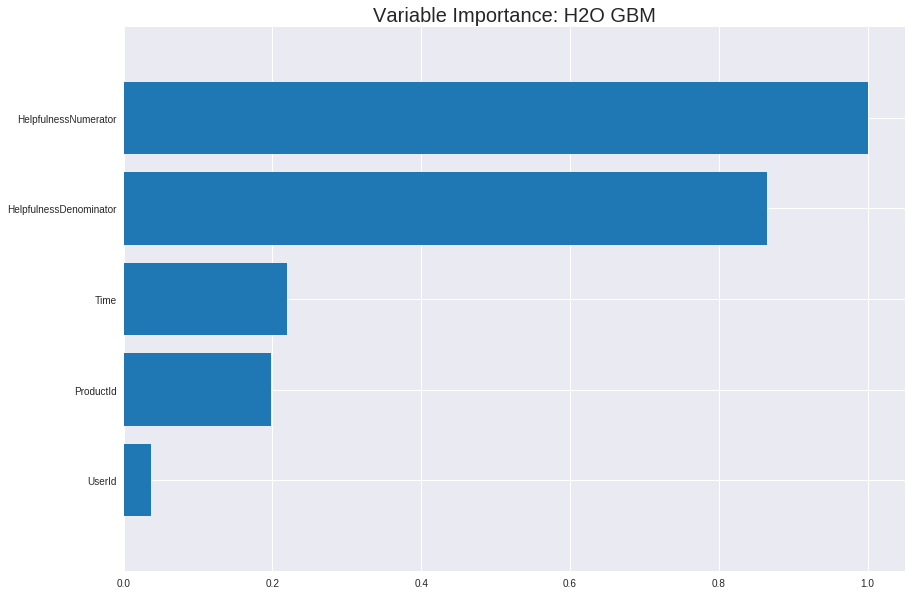

In [38]:
gbm_baseline.varimp_plot()